# SISTEMA DE RECOMENDACION

IMPORTAMOS LIBRERIAS

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re


CARGAMOS LOS DATOS

In [2]:
df_reviews = pd.read_csv('Data frames limpios/df_reviews_limpio.csv')
df_items = pd.read_csv('Data frames limpios/df_items_limpio.csv')
df_games = pd.read_csv('Data frames limpios/genres_desanidado.csv')

HACEMOS UN UNICO DATA FRAME 

In [3]:
final_r = ['user_id', 'funny','recommend']
final_i = ['user_id', 'id']
final_g = ['id', 'genres','app_name','specs','price','early_access','developer']

df_final_r = df_reviews[final_r]
df_final_i = df_items[final_i]
df_final_g = df_games[final_g]

df_recomendacion = pd.merge(df_final_r, df_final_i, on= 'user_id')
df_recomendacion = pd.merge(df_recomendacion, df_final_g, on= 'id')

# LIMPIEZA DE LOS DATOS

In [4]:
#Dejamos las recomendaciones positivas nomas y eliminamos la columna recommend
df_recomendacion = df_recomendacion[df_recomendacion['recommend'] == True]
df_recomendacion = df_recomendacion.drop('recommend', axis=1)

In [5]:
#Borramos nulos en base a las columna genres y despues igual por la columna de developer
df_recomendacion = df_recomendacion.dropna(subset=['genres'])
df_recomendacion = df_recomendacion.dropna(subset=['developer'])

In [6]:
#Borramos los duplicados
df_recomendacion = df_recomendacion.drop_duplicates()

In [7]:
#Reseteamos el indice
df_recomendacion = df_recomendacion.reset_index(drop=True)

In [8]:
#Borramos la columna user_id y le asignamos un nuevo nombre a la variable del df
recomendacion_final = df_recomendacion.drop('user_id', axis=1)

In [9]:
#Borramos duplicados
recomendacion_final = recomendacion_final.drop_duplicates()

In [10]:
#Reseteamos el indice
recomendacion_final = recomendacion_final.reset_index(drop=True)

In [11]:
#Borramos cuando la columna early_acces es True (es decir borramos la recomendaciones de gente que probo un modelo del juego que no estaba finalizado) y borramos la columna
recomendacion_final = recomendacion_final.drop(recomendacion_final[recomendacion_final['early_access'] == True].index)
recomendacion_final = recomendacion_final.drop('early_access', axis=1)

In [12]:
#Borramos los nulos en base a la columna funny
recomendacion_final = recomendacion_final.dropna(subset=['funny'])

AGREGAMOS LA COLUMNA FUNNY_NUMBER

In [13]:
# Definimos una función para extraer el número 
def extract_number(text):
    # Utilizamos una expresión regular para encontrar un número en el texto
    match = re.search(r'\d+', text)
    
    # Si encontramos un número, lo devolvemos como entero; de lo contrario, devuelve NaN
    if match:
        return int(match.group())
    else:
        return None

# Aplicamos la función a la columna 'funny' y creamos una nueva columna 'funny_number'
recomendacion_final['funny_number'] = recomendacion_final['funny'].apply(extract_number)


In [14]:
#Borramos la columna funny
recomendacion_final = recomendacion_final.drop('funny', axis=1)

In [15]:
# Agrupamos el DataFrame por las columnas 'id', 'genres', 'app_name', 'specs', 'price', 'developer'
# y sumamos la columna 'funny_number'
recomendacion_final = recomendacion_final.groupby(['id', 'genres', 'app_name', 'specs', 'price', 'developer'])['funny_number'].sum().reset_index()

# FUNCION DE RECOMENDACION DE JUEGOS

In [16]:
def recomendacion_juego(id_ingresado):
    # Verificamos si el 'id_ingresado' está en la columna 'id'
    if id_ingresado in recomendacion_final['id'].values:
        # Filtramos por 'id'
        df_filtrado = recomendacion_final[recomendacion_final['id'] == id_ingresado]

        # Filtramos por 'genres'
        if not df_filtrado.empty:
            genre = df_filtrado.iloc[0]['genres']
            df_filtrado = recomendacion_final[recomendacion_final['genres'] == genre]

            # Filtramos por 'specs'
            if not df_filtrado.empty:
                df_filtrado = df_filtrado[df_filtrado['specs'] == df_filtrado.iloc[0]['specs']]

                # Filtramos por 'developer'
                if not df_filtrado.empty:
                    df_filtrado = df_filtrado[df_filtrado['developer'] == df_filtrado.iloc[0]['developer']]

                    # Filtramos por 'funny_number'
                    if not df_filtrado.empty:
                        df_filtrado = df_filtrado.sort_values(by='funny_number', ascending=False)

                        # Devolvemos los nombres de los juegos recomendados
                        if not df_filtrado.empty:
                            nombres_recomendados = df_filtrado['app_name'].iloc[:5].tolist()
                            return nombres_recomendados
            else:
                return "No se encontraron juegos con los mismos criterios."
        else:
            return "No se encontraron juegos con el género ingresado."
    else:
        return "No se encontraron juegos con el ID ingresado."


In [17]:
recomendacion_juego(10)

['Counter-Strike',
 'Team Fortress Classic',
 'Day of Defeat',
 'Ricochet',
 'Half-Life Deathmatch: Source']

GRAFICOS


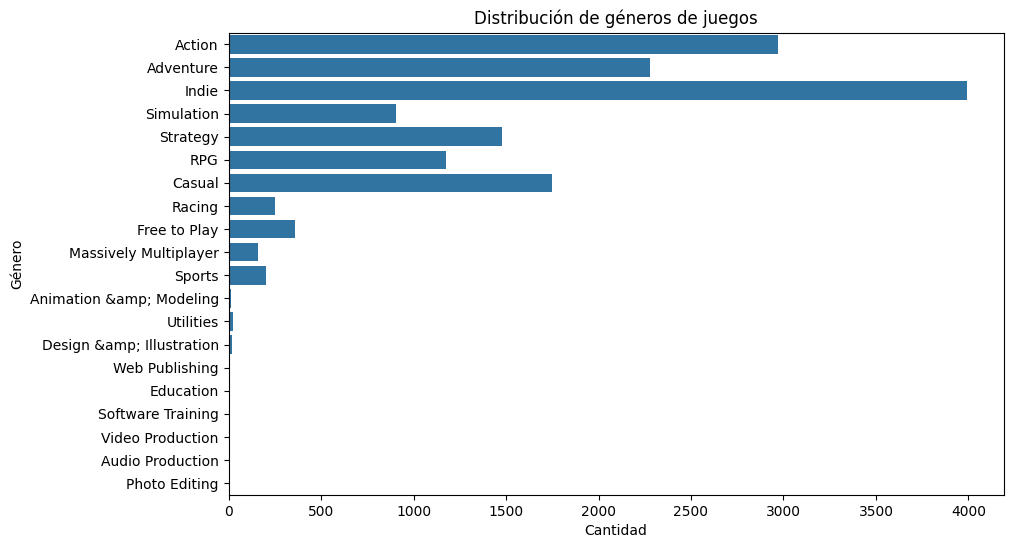

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(data=recomendacion_final, y='genres')
plt.title("Distribución de géneros de juegos")
plt.ylabel("Género")
plt.xlabel("Cantidad")  
plt.show()


In [19]:
recomendacion_final.describe(include= 'all')

,id,genres,app_name,specs,price,developer,funny_number
count,15605.000000,15605,15605,15605,15605,15605,15605.000000
unique,NaN,20,6523,1295,79,4262,NaN
top,NaN,Indie,Marble Mayhem: Fragile Ball,['Single-player'],9.99,Warfare Studios,NaN
freq,NaN,3990,9,1592,3067,57,NaN
mean,308214.314771,NaN,NaN,NaN,NaN,NaN,550.083178
std,123905.883720,NaN,NaN,NaN,NaN,NaN,1588.701395
min,10.000000,NaN,NaN,NaN,NaN,NaN,1.000000
25%,252950.000000,NaN,NaN,NaN,NaN,NaN,10.000000
50%,330270.000000,NaN,NaN,NaN,NaN,NaN,68.000000
75%,393410.000000,NaN,NaN,NaN,NaN,NaN,380.000000


C:\Users\leand\AppData\Local\Temp\ipykernel_1984\3628237146.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genres',y='funny_number',data=recomendacion_final, palette= 'pastel')


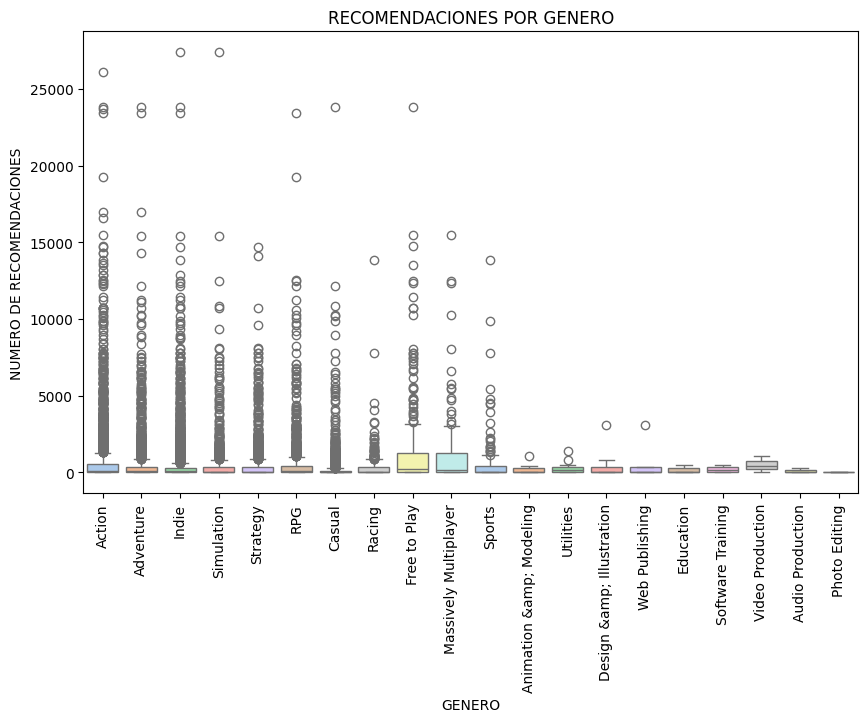

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='genres',y='funny_number',data=recomendacion_final, palette= 'pastel')
plt.title('RECOMENDACIONES POR GENERO')
plt.ylabel("NUMERO DE RECOMENDACIONES")
plt.xlabel("GENERO") 
plt.xticks(rotation=90)
plt.show()

CREAMOS UN ARCHIVO PARQUET CON EL DF FINAL

In [21]:
#recomendacion_final.to_parquet('recomendacion_final.parquet', index=True)